In [24]:
from IPython.display import display, Latex
from IPython.core.display import HTML
%reset -f
%matplotlib inline
%autosave 300
from matplotlib.pylab import *
from time import clock
from scipy.sparse import  spdiags
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix, csr_matrix, spdiags

Autosaving every 300 seconds


# Méthode élément fini
On présente la mise en oeuvre des éléments finis $\mathbb P_1$ 1D pour le problème de Robin suivant:
$$
\begin {align}
-u''(x)=f(x), \quad x\in ]0,L[,\\
-u'(0)+ a_0 u(0)=b_0,\\
u'(1)+ a_1 u(1)=b_1.
\end {align}
$$
où $f$ est donné dans $L^2(]0,L[)$ et les constantes $a_0$ et $a_1$ sont bien-sûr positives, dont au moins une stricte afin d'assurer l'ellipticité de l'opérateur sur l'espace $H^1(]0,L[)$. Il convient de vérifier en effet que toutes les hypothèses du théorème de Lax-Milgram sont vérifiées pour la formulation faible:
$$
\left (\mathcal V\right ) \begin {cases}
\text{Trouver } u\in H^1(]0,L[)\text{ tel que }\forall v\in H^1(]0,L[)\\
\int_0^L u'(x)v'(x)\,dx+a_0u(0)v(0)+a_1u(1)v(1)=\int_0^L f(x)v(x)\,dx+b_0v(0)+b_1v(1).
\end {cases}
$$
On notera $a(u,v)$ l'expression de la forme bilinéaire intervenant dans le membre de gauche de $\left (\mathcal V\right )$ et on notera $l(v)$ la forme linéaire intervenant dans le membre de droite de $\left (\mathcal V\right )$.
## Formulation faible approchée
On cherche à résoudre le problème approché en dimension finie,
$$
\left (\mathcal V_h\right ) \begin {cases}
\text{Trouver } u_h\in V_h\text{ tel que }\forall v\in V_h\\
\int_0^L u_h'(x)v'(x)\,dx+a_0u_h(0)v(0)+a_1u_h(1)v(1)=\int_0^L f(x)v(x)\,dx+b_0v(0)+b_1v(1),
\end {cases}
$$
où $V_h\subset H^1(]0,L[)$ est de dimension finie et 
$$
V_h=\{ v\in \mathcal C^0(]0,L[)\text{ tel que }v_{|[x_i,x_{i+1}]  }   \in \mathbb P_1,~\forall 0\le i< N-1\},
$$
avec $x_i=ih$ où $h$ est le pas de la subdivision uniforme de $[0,L]$, soit $h=\frac L {N-1}$.
## Base de l'espace d'approximation
On construit une base de $V_h$ à l'aide des fonctions chapeaux suivantes $\Phi_i$ pour $0\le i<N$,
$$
\begin {cases}
\Phi_i(x)=\frac {x-x_{i-1}} h \text { si }x_{i-1}\le x\le x_{i},\\
\Phi_i(x)=\frac {-x+x_{i+1}} h \text { si }x_{i}\le x\le x_{i+1},\\
\Phi_i(x)=0\text { sinon }.
\end {cases}
$$
On vérifie aisément que $\{\Phi_i \}_{0\le i< N}$ forme une famille libre et génératrice de $V_h$:
$$
\forall v\in V_h,\quad v=\sum_{i=0}^{N-1}v(x_i)\Phi_i.
$$
## Système linéaire associé à $\left (\mathcal V_h\right )$
On cherche $u_h$ qui se décompose sur la base $\{\Phi_i \}_{0\le i< N}$ de dimension $N$,
$$
u_h(x)=\sum_{i=0}^{N-1}u_i\Phi_i(x),\quad \forall x\in [0,L].
$$
On notera que les inconnues $u_i$ (coefficients scalaires dans la base) satisfont $u_i=u_h(x_i)$, ce qui sera bien pratique pour visualiser la solution sans avoir à reconstruire $u_h$.

Plutôt que de vérifier $\left (\mathcal V_h\right )$ pour tout $v\in V_h$, il suffit de vérifier la formulation variationelle pour tout $\Phi_i$, $0\le i<N$. On a ainsi $N$ équations scalaires pour $N$ inconnues. Soit le système matricielle,
$$
AU=F,\text{ avec }U=(u_0,\cdot,u_{N-1})^t, ~F=(l(\Phi_0),\cdot,l(\Phi_{N-1}))^t, \text{ et }A_{ij}=a(\Phi_j,\Phi_i).
$$
## Assemblage de la matrice
Dans le cas présent, il est facile d'identifier chacun des coefficients du système en remarquant que la matrice est tridiagonale compte tenu du support des fonctions de base qui s'interesctent seulement avec la fonction de base précédente et suivante. 
Il suffit alors de calculer $a(\Phi_i,\Phi_i)$, $a(\Phi_i,\Phi_{i-1})$ et $a(\Phi_i,\Phi_{i+1})$ en traitant à part $i=0$ et $i=N-1$.

Néanmoins, dans un soucis de généralisation, nous allons présenter une méthode qui s'appliquera tout aussi simplement en dimension supérieure. Cette méthode consiste à construire une matrice dite élémentaire qui évalue le calcul intégral de la formulation faible sur un élément fini et l'assemblage de la matrice globale $A$ se faisant alors par somme des contributions venant de chaque élément.

On construit la matrice élémentaire
$$
el=\left (\begin {matrix}
\int_0^h \varphi_1'(x)\varphi_1'(x)\, dx &\varphi_1'(x)\varphi_2'(x)\, dx\\
\int_0^h \varphi_2'(x)\varphi_1'(x)\, dx &\varphi_2'(x)\varphi_2'(x)\, dx,\\
\end {matrix}\right )
$$
où, quitte à translater l'intervalle de $x_k$, $\varphi_1$ est la restriction de $\Phi_{k+1}$ à $[x_k,x_{k+1}]$ et $\varphi_2$ est la restriction de $\Phi_{k}$ à $[x_k,x_{k+1}]$. Sur $[0,h]$, on a 
$$
\varphi_2(x)=\frac {x}{h},\quad \varphi_1(x)=\frac {h-x}{h}.
$$
Ainsi,
$$
el=\frac 1 {h}\left (\begin {matrix}
1 &-1\\
-1&1\\
\end {matrix}\right ).
$$
La clé du remplissage de la matrice globale $A$ repose sur la formule
$$
\int_0^L \Phi_i'(x)\Phi_j'(x)\,dx=\sum_{k=0}^{N-2}\int_{x_k}^{x_{k+1}} \Phi_i'(x)\Phi_j'(x)\,dx,
$$
mais aussi sur le fait que sur l'intervalle $[x_k,x_{k+1}]$ la contribution des termes $\Phi_i$ et $\Phi_j$ est non trivial lorsque ceux-ci sont les fonctions de base attachés au sommet $x_k$ et $x_{k+1}$. A une translation près, ce sont les fonctions $\varphi_1$ et $\varphi_2$.

## Construction du second membre
La construction du second membre nécessite le calcul de 
$$
\int_0^L f(x)\Phi_k(x)\,dx+b_0\Phi_k(0)+b_1\Phi_k(1).
$$
Les termes provenant des conditions limites inhomogènes de Robin sont triviaux à calculer et n'apparaissent que si $k=0$ ou si $k=N-1$.
Le terme intégral est plus compliqué. On se contentera d'une formule de quadrature pour l'approcher. Une formule des trapèzes basée sur la subdivision $(x_i)_{i=0}^{n-1}$ donne,
$$
\int_0^L f(x)\Phi_k(x)\,dx\sim h\left (\frac {f(x_0)\Phi_k(x_0)} 2+\sum_{l=1}^{N-1}f(x_l)\Phi_k(x_l)+\frac {f(x_{N-1})\Phi_k(x_{N-1})} 2\right ).
$$
Mais comme $\Phi_k(x_l)=\delta_{kl}$,
$$
\begin {cases}
F_0=h\frac {f(x_0)} 2 +b_0,\\
F_k=hf(x_k),~0<k<N-1,\\
F_{N-1}=h\frac {f(x_{N-1})} 2 +b_1.
\end {cases}
$$

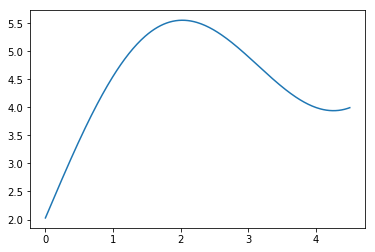

In [25]:
N=300
L=4.5
h=L/(N+1)
#remplissage de la matrice
#le format  LIL (list de list) permet de remplir 
#les coefficients d'une matrice creuse en accedant à sa position 
#ligne colonne
#A est ici initialisée à la matrice nulle de la taille considérée
A =lil_matrix((N, N))
#construction de la matrice élémentaire du terme integral
el=array([[1,-1],[-1,1]])/h
#Parcours des éléments
for k in range(N-1):
    S=array([k,k+1])# ce tableau contient les numéros des 2 sommets
    for i in range(2):
        for j in range(2):
            A[S[i],S[j]]=A[S[i],S[j]]+el[i,j]
# la matrice A ici construite ne contient que la contribution 
#intégrale, soit celle qu'on aurait eu avec de CL de Neuman homogène
# la matrice a donc une valeur propre nulle associée au vecteur propre
#qui ne contient que des composantes identiques.
#On peut vérifier que la somme des coefficients par ligne fait 0
#
#On va rajouter les termes provenant des CL de Robin
a0=100
a1=100
A[0,0]=A[0,0]+a0
A[N-1,N-1]=A[N-1,N-1]+a1

#construction du second membre
b0=200
b1=400
x=linspace(0,L,N)
fx=2*sin(x)#on a choisi f(x)=2sin(x) 
F=h*fx
F[0]=F[0]*0.5+b0
F[N-1]=F[N-1]*0.5+b1
#conversion en csr (compressed storage row) pour resolution system
A=A.tocsr()
#resolution systeme creux
U=spsolve(A,F)
plot(linspace(0,L,N),U)

# Exercices
## Validation
Réaliser une validation de ce code. Il faudra d'abord réécrire sous forme de fonction paramétrée par $N$ le calcul de la solution approchée sur la subdivision à $N$ points.
## Validation Dirichlet
Par un choix pertient de $a_0$, $a_1$, $b_0$ et $b_1$, proposer avec le même code une validation pour un problème de Dirichlet inhomogène.
## Elément fini $\mathbb P_2$
Proposer la construction de l'approximation $\mathbb P_2$ conforme de Lagrange pour ce même problème de Robin inhomogène. Vérifier l'ordre de la méthode obtenue. On choisira alors une approximation par formule de Quadrature de Simpson pour le calcul du second membre.